# Setup

In [1]:
%%capture
%pip show transformers
%pip show accelerate
%pip install transformers[torch] -U
%pip install accelerate -U
%pip install transformers
%pip install pytorch-lightning
%pip install --upgrade transformers
%pip install datasets

# Preprocessing

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it



# Train Data - 52662 rows after pre-processing (done above)
toxicity_train_df = pd.read_csv('train-2.csv')
toxicity_train_df = toxicity_train_df.dropna()

# # Test Data - 7287 rows after pre-processing
# toxicity_test_df = pd.read_csv('test-2.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
# toxicity_test_df = toxicity_test_df.dropna()

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
# toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.33 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.33).any(axis=1).astype(float)
# toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.33).any(axis=1).astype(float)

# Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
# toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
# toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

# Can be adjusted to downsample training data
sample_rate = 1.0

toxicity_train_df = toxicity_train_df.sample(frac=sample_rate, random_state=42)

print("Toxic train examples")
print(toxicity_train_df.head(4))

# print("Toxic test examples")
# print(toxicity_test_df.head(4))

Toxic train examples
                                              comment_text  toxic  obscene  \
516043   Omigod, a woman wearing a head scarf.  What wo...    0.0      0.0   
1054055  One that actually proves that instead of being...    0.0      0.0   
29890           We are one.  Not female or male but human.    0.0      0.0   
1298142  I understand that a police force day in and da...    0.0      0.0   

         sexual_explicit  threat  insult  identity_attack  
516043               0.0     0.0     0.0              0.0  
1054055              0.2     0.0     0.3              0.2  
29890                0.0     0.0     0.0              0.0  
1298142              0.0     0.0     0.0              0.0  


Test Lengths of DFs

In [3]:
print(len(toxicity_train_df))
# print(len(toxicity_test_df))

235085


# Visualization of toxicity in train

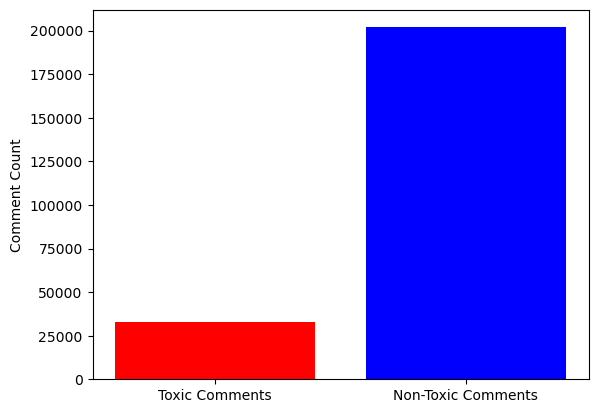

In [4]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

In [5]:
# # Count toxic and non-toxic comments
# toxic_count = toxicity_test_df['toxic'].sum()
# non_toxic_count = len(toxicity_test_df) - toxic_count

# # Plot side-by-side bars for toxic and non-toxic comments
# labels = ['Toxic Comments', 'Non-Toxic Comments']
# counts = [toxic_count, non_toxic_count]

# plt.bar(labels, counts, color=['red', 'blue'])
# plt.ylabel('Comment Count')

# plt.show()

# Splitting and Labelling

In [6]:
model_name = "roberta-base"

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
# toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'toxic']].dropna()
# test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['toxic'].tolist()
# test_texts = test_data['comment_text'].tolist()
# test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
# print("test_texts")
# print(test_texts[:5])
# print("test_labels:")
# print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


train_texts:
['Omigod, a woman wearing a head scarf.  What would our mothers or grandmothers in the 1950s have said?', 'One that actually proves that instead of being a distortion or projection.\n\nConsider the accusation that he "called Mexicans racists".  It\'s false.  You read his quote and he called some illegal immigrants rapists.  In case after case if you look at his actual words you find you\'ve been lied to by the media.', 'We are one.  Not female or male but human.', "I understand that a police force day in and day out serves the protective needs of its' citizenry, as they were in this circumstance locating and removing weaponry designed to kill people, from a group that is a criminal organization.  Do you understand the function of the police?", "The truth is the truth, even if no one believes it.  A lie is a lie, even if everyone believes it.  \n\nThere are very few with the ridiculous 6 figures and yes, I agree that is ridiculous.  But the rest of us came on and spent our 

# Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
# test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(2):  # Print first 2 samples
    # sample = test_dataset[i]
    # print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

c:\Users\joshs\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Train Dataset
Sample 1:
Encoding keys: ['<s>', 'The', 'Ġdemocr', 'ats', 'Ġare', 'Ġfar', 'Ġfrom', 'Ġperfect', 'Ġbut', 'Ġthe', 'Ġdummy', 'Ġrepublic', 'ans', 'Ġare', 'Ġjust', 'Ġout', 'Ġto', 'Ġlunch', '.', 'Ġ', 'ĠCome', 'Ġon', 'ĠDonald', 'Ġdo', 'Ġwhat', 'Ġyou', 'Ġpromised', 'Ġand', 'Ġrelease', 'Ġyour', 'Ġtax', 'Ġreturns', '!', 'Ġ', 'ĠCome', 'Ġon', 'ĠDonald', 'Ġgive', 'Ġus', 'Ġa', 'Ġhealth', 'Ġsystem', 'Ġthat', 'Ġwill', 'Ġcover', 'Ġeveryone', 'Ġand', 'Ġbe', 'Ġmuch', 'Ġbetter', '.', 'Ġ', 'ĠBut', 'Ġno', 'Ġyou', 'Ġhave', 'Ġdecided', 'Ġto', 'Ġgo', 'Ġback', 'Ġon', 'Ġyour', 'Ġhealth', 'Ġcare', 'Ġpledge', 'Ġand', 'Ġare', 'Ġgiving', 'Ġus', 'Ġthis', 'Ġcr', '*', 'p', 'Ġfrom', 'Ġthe', 'Ġhouse', '.', 'Ġ', 'ĠFor', 'Ġshame', 'ĠDonald', '!', 'Ġ', 'ĠJust', 'Ġgoes', 'Ġto', 'Ġshow', ',', 'Ġnever', 'Ġtrust', 'Ġa', 'Ġrep', 'ib', 'lic', 'an', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

# Native PyTorch (instead of HF Trainer)

In [8]:
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import torch
import random

# Set random seed for reproducability
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Access GPU or CPU depending on status
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Grab generic roberta-base model to be fine tuned
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
model.to(device)
model.train()

# Initialize training params
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
optim = AdamW(model.parameters(), lr=1e-5)
num_train_epochs = 1

# Fine-tuned roberta-base model
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]
      total_loss += loss.item()

      loss.backward()
      optim.step()

      if (batch_idx + 1) % 50 == 0:  # Print progress every 50 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

model.eval()

# Store the fine-tuned model for later use
model.save_pretrained('fine_tuned_roberta')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\joshs\anaconda3\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/1], Batch [50/188068], Loss: 0.1188
Epoch [1/1], Batch [100/188068], Loss: 0.1445
Epoch [1/1], Batch [150/188068], Loss: 0.1359
Epoch [1/1], Batch [200/188068], Loss: 0.1295
Epoch [1/1], Batch [250/188068], Loss: 0.1294
Epoch [1/1], Batch [300/188068], Loss: 0.1226
Epoch [1/1], Batch [350/188068], Loss: 0.1226
Epoch [1/1], Batch [400/188068], Loss: 0.1298
Epoch [1/1], Batch [450/188068], Loss: 0.1298
Epoch [1/1], Batch [500/188068], Loss: 0.1303
Epoch [1/1], Batch [550/188068], Loss: 0.1330
Epoch [1/1], Batch [600/188068], Loss: 0.1340
Epoch [1/1], Batch [650/188068], Loss: 0.1338
Epoch [1/1], Batch [700/188068], Loss: 0.1326
Epoch [1/1], Batch [750/188068], Loss: 0.1332
Epoch [1/1], Batch [800/188068], Loss: 0.1293
Epoch [1/1], Batch [850/188068], Loss: 0.1262
Epoch [1/1], Batch [900/188068], Loss: 0.1287
Epoch [1/1], Batch [950/188068], Loss: 0.1267
Epoch [1/1], Batch [1000/188068], Loss: 0.1272
Epoch [1/1], Batch [1050/188068], Loss: 0.1268
Epoch [1/1], Batch [1100/188068],

Download file paths (if desired)

Sometimes can alter the json file and cause the subsequent code cells to fail. Hence, commented out for now.

In [9]:
# from google.colab import files

# # Paste the path you copied as the argument to files.download()

# from tqdm import tqdm
# from google.colab import files

# # File paths to download
# file_paths = ['/usr/fine_tuned_roberta_model_2/config.json', '/usr/fine_tuned_roberta_model_2/model.safetensors']

# # Loop through each file and download with tqdm progress bar
# for file_path in file_paths:
#     with open(file_path, 'wb') as f:
#         with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
#                   desc=file_path.split('/')[-1]) as pbar:
#             # Download the file
#             files.download(file_path)
#             # Manually update progress bar
#             pbar.update()

# Default RoBERTa test as baseline

In [10]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base')


# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
count = 0

def predict_label(row):
    global count
    text_to_predict = row['comment']

    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if ((np.abs(probabilities[1] - probabilities[0]) <= 0.061) and (probabilities[0] < 0.5425)) else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 10):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(probabilities)
      # The difference in probabilities represents a confidence interval which is also important to evaluate
      print(np.abs(probabilities[1] - probabilities[0]))
      print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasan_abi_11.19.22_test.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['base_prediction'] = twitch_df.apply(predict_label, axis=1)

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df['base_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: 'hasan_abi_11.19.22_test.csv'

# Base Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user             17480 non-null  object
 1   comment          17480 non-null  object
 2   base_prediction  17480 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 409.8+ KB
None
2     LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH L...
9     LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LE...
11    LEFTERS ANY LEFTERS? LEFTERS ANY LEFTERS? LEFT...
35    LEFTERS LIBBERS HOGGERS LIBS ARE THE TRUE CENT...
36    nesuaLove RUSTY OHIO RAID nesuaFeet RUSTY OHIO...
Name: comment, dtype: object


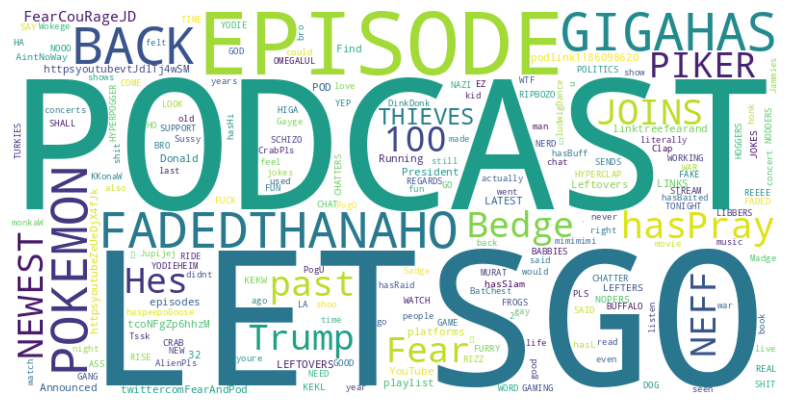

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

print(twitch_df.info())

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['base_prediction'] == 1]['comment']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
!pip install better-profanity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.0 MB/s eta 0:00:00


# Fine-Tuned Roberta on Wikipedia Dataset

In [ ]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

def contains_profanity(text):
    return profanity_check.predict([text])[0]

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['comment']
    # Filter out mentionings of Twitch subscriptions and tiers
    sub_mention = any(keyword in text_to_predict for keyword in ["Tier 1", "subscribed with Prime", "subbed using Prime"])
    # Leverages better profanity to catch additional profanity occurences
    profanity_in = profanity.contains_profanity(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if profanity_in or (np.abs(probabilities[0]) > 0.56 and not sub_mention) or (np.abs(probabilities[0]) < 0.5499 and not sub_mention)else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasan_abi_11.19.22_test.csv')
print(f"Total length of test stream: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_wiki_prediction'] = twitch_df.apply(predict_label, axis=1)

prediction_counts = twitch_df['roberta_wiki_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])

Total length of test stream: 17480
Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR OLD MAN YELLING AT TROLLS Drake ONLY FUN REACTS AND GAMES Drake 󠀀
0.57878476
1
@HORSTBEFEHL D: how dare u call smol bear a stinky
0.6214199
1
LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH
0.55371433
0
SHE BE JEJING MY JUPI Jupijej Jupijej Jupijej
0.55507386
0
peepoHey Hey Chat I hope you're having a great weekend peepoKiss
0.5589057
0
I hope everyone is having a great day hasL
0.55698735
0
@elhijodejackslid if you ever see me say live, I'm not trolling :P
0.56378746
1
SHE  BE JEJING MY JUPI Jupijej Jupijej Jupijej
0.5546007
0
Was not expecting to be here so soon
0.556791
0
LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE
0.5449815
1
SEE YOU ON THE OTHER SIDE OFFLINE

Note the ***detection of new toxic words*** not found in previous stream: Lefters, Libbers, Hoggers (assuming political connotations).

Note the ***detection of user toxicity*** such as "Yelling at Trolls", and "I'm not trolling", "CLICKBAIT".

Note the filtering out of typical Twitch platform messages subscription mentioning: "Tier 1, has subscribed, etc".

See Excel file for more details if curious.

Save Predictions for Fine-Tuned Wikipedia Model

In [ ]:
# Define the file path for the Excel file
excel_file_path = "/usr/roberta_wiki_predictions_final.xlsx"

# Save the 'roberta_wiki_prediction' column to an Excel file
twitch_df['roberta_wiki_prediction'].to_excel(excel_file_path, index=False)

# Fine-Tuned Wikipedia Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR ...
1     @HORSTBEFEHL D: how dare u call smol bear a st...
6     @elhijodejackslid if you ever see me say live,...
9     LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LE...
11    LEFTERS ANY LEFTERS? LEFTERS ANY LEFTERS? LEFT...
Name: comment, dtype: object


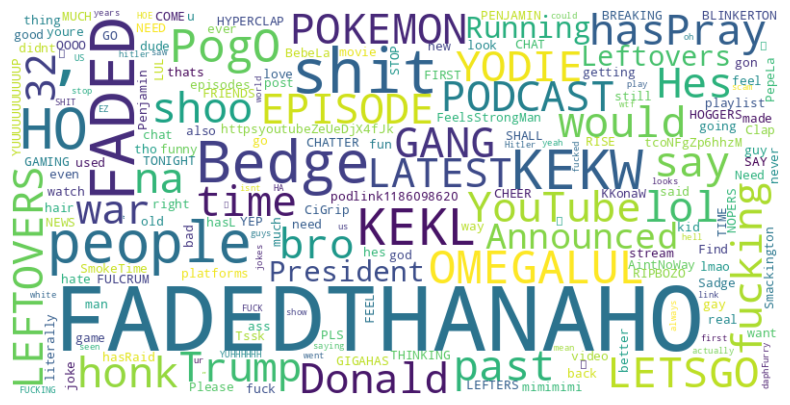

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['roberta_wiki_prediction'] == 1]['comment']
print(toxic_comments.head(5))

batch_size = 1000  # Set the batch size
num_rows = len(twitch_df)
with open('union_output.txt', 'w') as f:
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        for index, row in twitch_df.iloc[start:end].iterrows():
            f.write(str(row['roberta_wiki_prediction']) + '\n')

# from google.colab import files
# files.download('union_output.txt')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Preprocessing on Twitch Union dataset

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

# Train Data (Roberta + Llama Union), 11449 rows
toxicity_train_df = pd.read_csv('toxic_union.csv',  on_bad_lines='skip')
toxicity_train_df = toxicity_train_df.dropna()

# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()

# Only check these categories in toxicity_test since train is our union csv
# built from the previous fine-tuning and training cells
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.33 threshold
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.33).any(axis=1).astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

<ipython-input-25-c6d20f958abc>:23: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)


Toxic train examples
                                        comment_text  toxic  llama  union
0  Confused why people are spamming things like J...      0      0      0
1       Nice thats my first time in Hasan Lifestream      0      1      1
2     THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO      0      0      0
3  Dont forget to check ur cocks before stream st...      0      0      0
Toxic test examples
                                          comment_text  toxic  obscene  \
24                                                BS !    0.0      0.0   
56   Hodad...does your user handle refer to your da...    0.0      0.0   
156  Many of them were wearing red Na'i Aupuni shir...    0.0      0.0   
181  "Methinks your comment is indicative of your n...    0.0      0.0   

     sexual_explicit    threat  insult  identity_attack  
24               0.0  0.000000     0.0              0.0  
56               0.0  0.000000     0.0              0.0  
156              0.0  0.000000     0.0      

<ipython-input-25-c6d20f958abc>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
<ipython-input-25-c6d20f958abc>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.33).any(axis=1).astype(float)
<ipython-input-25-c6d20f958abc>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Test DF lengths

In [ ]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

11449
7287


# Visualization of Toxicity in Union Dataset

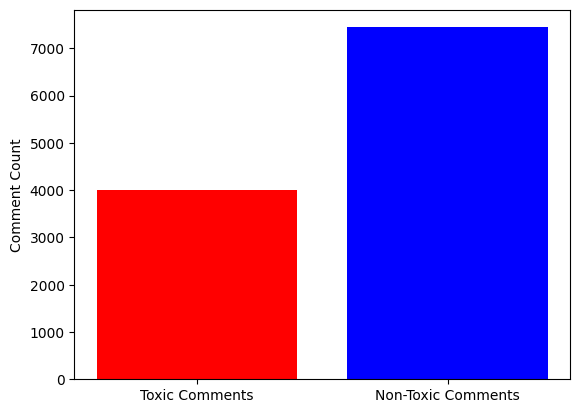

In [ ]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['union'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Union Dataset Wordcloud

***What are the most common toxic words in our Union Dataset?***

Union Dataset: Represents the union of Llama 7-b zero-shot labeling, and RoBERTa NLP model fine-tuned on Wikipedia comments on toxic Twitch comments

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1          Nice thats my first time in Hasan Lifestream
5           hey guys I'm finally here early, I love you
8     HYPERPOGGER I was here on accident. Catching u...
12    @rythympnxa naber agam @HasanAbi izlemeye mi g...
16    hasL hasL hasL hasL hasRaid hasRaid hasL hasL ...
Name: comment_text, dtype: object


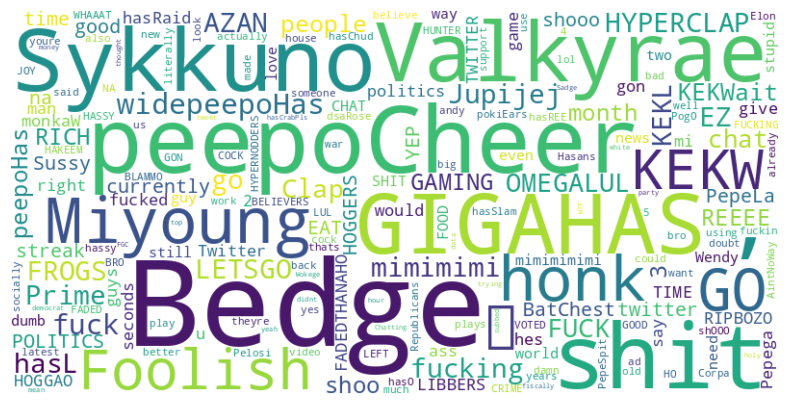

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = toxicity_train_df[toxicity_train_df['union'] == 1]['comment_text']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Splitting & Labeling + Dataset creation



In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'union']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['union'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

train_texts:
["Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej", 'Nice thats my first time in Hasan Lifestream', 'THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO', 'Dont forget to check ur cocks before stream starts', 'THE HASANABI IS REAL LETSGO THE HASANABI IS REAL LETSGO']
train_labels:
[0, 1, 0, 0, 0]
test_texts
['BS !', 'Hodad...does your user handle refer to your daughter??', "Many of them were wearing red Na'i Aupuni shirts.  Does that not show support for federal recognition?", '"Methinks your comment is indicative of your need to understand the Christian faith which does not require the subservience of woman as much as care and love for them by the man - ""as Christ loved the church""."', "And sometimes it's just salting the earth..."]
test_labels:
[0.0, 0.0, 0.0, 0.0, 0.0]
Train Dataset
Sample 1:
Encoding keys: ['<s>', 'who', 'Ġdo', 'Ġyou', 'Ġwant', 'Ġto'

# Training on Union

In [ ]:
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import torch

# Set random seed for reproducability
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Access the once fine-tuned RoBERTa model we just created
# (not the same as RoBERTa toxicity standard used below see desc for explanation)
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')
model.to(device)
model.train()

# Initialize training parameters
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optim = AdamW(model.parameters(), lr=1e-6)
num_train_epochs = 1

# Train on the union of Llama 7-b and RoBERTa toxicity standard
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]
      total_loss += loss.item()

      loss.backward()
      optim.step()

      if (batch_idx + 1) % 50 == 0:  # Print progress every 50 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

model.eval()

model.save_pretrained('/usr/fine_tuned_roberta_model_union')

Epoch [1/1], Batch [50/573], Loss: 0.2013
Epoch [1/1], Batch [100/573], Loss: 0.1978
Epoch [1/1], Batch [150/573], Loss: 0.1987
Epoch [1/1], Batch [200/573], Loss: 0.1963
Epoch [1/1], Batch [250/573], Loss: 0.1931
Epoch [1/1], Batch [300/573], Loss: 0.1889
Epoch [1/1], Batch [350/573], Loss: 0.1889
Epoch [1/1], Batch [400/573], Loss: 0.1864
Epoch [1/1], Batch [450/573], Loss: 0.1856
Epoch [1/1], Batch [500/573], Loss: 0.1851
Epoch [1/1], Batch [550/573], Loss: 0.1827
Epoch [1/1], Average Loss: 0.1825


***How are the RoBERTa models different?***

Great question. The RoBERTa models vary in that the first one created focuses on the fine-tuning using a toxicity definition that focuses on five specific sub-categories of toxicity (insult, threat, obscene, identity_hate, sexually_explicit). This gives us a more focused definition for toxicity than the [RoBERTa toxicity standard model](https://huggingface.co/s-nlp/roberta_toxicity_classifier), which also uses Wikipedia comments, but has a more generalizable definition of toxic and features much more data. Thus, the Union represents the Union of Llama 7-b with the RoBERTa standard model as both should have a lot more context and generalizability than the once fine-tuned version of RoBERTa.

# Fine-tuned Union (RoBERTa / Llama) Predictions

In [ ]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model_union')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

# Returns whether text contains profanity
def contains_profanity(text):
    return profanity_check.predict([text])[0]

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['comment']
    # Remove any generic Twitch platform subscription comments
    sub_mention = any(keyword in text_to_predict for keyword in ["Tier 1", "subscribed with Prime", "subbed using Prime"])
    # Employ profanity checker for more robust toxic comment detection in case some words or acronyms
    # are missed initially by classifier
    profanity_in = profanity.contains_profanity(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if profanity_in or (np.abs(probabilities[0]) > 0.577 and not sub_mention) or (np.abs(probabilities[0]) < 0.551 and not sub_mention) else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 20):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasan_abi_11.19.22_test.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['union_prediction'] = twitch_df.apply(predict_label, axis=1)

# Grab prediction counts
prediction_counts = twitch_df['union_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])

17480
Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR OLD MAN YELLING AT TROLLS Drake ONLY FUN REACTS AND GAMES Drake 󠀀
0.6296182
1
@HORSTBEFEHL D: how dare u call smol bear a stinky
0.665515
1
LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH
0.579737
1
SHE BE JEJING MY JUPI Jupijej Jupijej Jupijej
0.57962805
1
peepoHey Hey Chat I hope you're having a great weekend peepoKiss
0.5787751
1
I hope everyone is having a great day hasL
0.55906075
0
@elhijodejackslid if you ever see me say live, I'm not trolling :P
0.5605722
0
SHE  BE JEJING MY JUPI Jupijej Jupijej Jupijej
0.57780397
1
Was not expecting to be here so soon
0.55554724
0
LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE
0.5915567
1
SEE YOU ON THE OTHER SIDE OFFLINERS hasL hasL hasL
0.574442
0
LE

In [ ]:
# Define the file path for the Excel file
excel_file_path = "/usr/roberta_union_predictions_final.xlsx"

# Save the 'roberta_wiki_prediction' column to an Excel file
twitch_df['union_prediction'].to_excel(excel_file_path, index=False)

# Double fine-tuned WordCloud

0    Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR ...
1    @HORSTBEFEHL D: how dare u call smol bear a st...
2    LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH L...
3        SHE BE JEJING MY JUPI Jupijej Jupijej Jupijej
4    peepoHey Hey Chat I hope you're having a great...
Name: comment, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

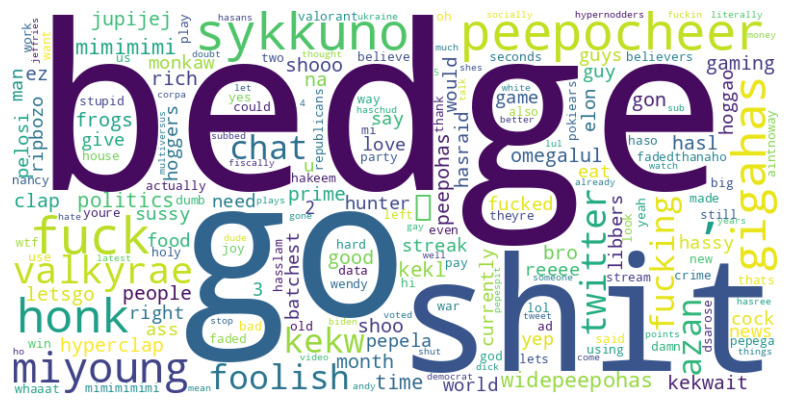

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['union_prediction'] == 1]['comment']
print(toxic_comments.head(5))

from google.colab import files
files.download('union_output.txt')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make', 'hes', 'back',
                         'see', 'im', 'make', 'think', 'one', 'every', 'running',
                         'take', 'day', 'really', 'Trump', 'EPISODE', 'PODCAST', 'Episode',
                         'Podcast', 'leftovers', 'trump', 'episode', 'podcast']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Convert all words to lowercase before removing stopwords
tokens = [word.lower() for word in tokens]

# Remove stop words
tokens = [word for word in tokens if word not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
